In [172]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score as auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import numpy as np

from func import rm_high_corr_feat

# Model 1 - Агрегированные данные по командам

In [173]:
df = pd.read_csv('../prepare_data/data/df_res.csv')

In [174]:
df = df[df['gameweek_compSeason_label'] > 2019]

In [175]:
df['teams_team_1_name'].unique()

array(['Wolverhampton Wanderers', 'Tottenham Hotspur',
       'Nottingham Forest', 'Manchester City', 'Liverpool', 'Fulham',
       'Crystal Palace', 'Aston Villa', 'Newcastle United',
       'Manchester United', 'Everton', 'Chelsea', 'Burnley', 'Brentford',
       'Bournemouth', 'Arsenal', 'West Ham United', 'Sheffield United',
       'Southampton', 'Leicester City', 'Leeds United', 'Norwich City',
       'Watford', 'West Bromwich Albion'], dtype=object)

In [176]:
df

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,team_1_hue,_accurate_back_zone_pass_team_1,_accurate_chipped_pass_team_1,_accurate_corners_intobox_team_1,_accurate_cross_team_1,...,_total_through_ball_lag_team2,_total_throws_lag_team2,_total_yel_card_lag_team2,_touches_lag_team2,_touches_in_opp_box_lag_team2,_unsuccessful_touch_lag_team2,_wins_lag_team2,_won_contest_lag_team2,_won_corners_lag_team2,_won_tackle_lag_team2
0,20,2023,Wolverhampton Wanderers,Everton,Molineux Stadium,1,7582.25,832.750000,43.750000,160.250000,...,39.0,707.0,79.0,21481.0,786.0,605.0,8.0,303.0,175.0,424.0
1,20,2023,Tottenham Hotspur,Bournemouth,Tottenham Hotspur Stadium,1,8308.50,685.500000,41.750000,140.500000,...,49.0,706.0,69.0,21201.0,743.0,588.0,11.0,320.0,144.0,371.0
2,20,2023,Nottingham Forest,Manchester United,The City Ground,1,5016.00,601.000000,29.000000,104.000000,...,105.0,715.0,78.0,25964.0,1093.0,497.0,23.0,319.0,195.0,400.0
3,20,2023,Manchester City,Sheffield United,Etihad Stadium,1,10041.25,918.750000,65.750000,168.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,2023,Liverpool,Newcastle United,Anfield,1,9401.25,967.750000,64.250000,195.500000,...,88.0,728.0,62.0,23410.0,1223.0,576.0,19.0,349.0,270.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,1,10041.25,918.750000,65.750000,168.500000,...,17.0,797.0,68.0,21368.0,726.0,546.0,9.0,352.0,201.0,291.0
1182,1,2020,Liverpool,Leeds United,Anfield,1,9401.25,967.750000,64.250000,195.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,0,7339.00,670.000000,53.000000,181.500000,...,67.0,756.0,86.0,25916.0,876.0,547.0,14.0,411.0,232.0,336.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,1,6535.25,618.500000,46.000000,141.000000,...,27.0,950.0,53.0,23611.0,879.0,654.0,15.0,423.0,210.0,416.0


In [177]:
n = 250

train = df.iloc[n:, :]
val = df.iloc[:n, :]

y_train = train['team_1_hue']
x_train = train.drop('team_1_hue', axis=1)

y_val = val['team_1_hue']
x_val = val.drop('team_1_hue', axis=1)

In [178]:
cat = ['gameweek_gameweek',	'gameweek_compSeason_label', 'teams_team_1_name', 'teams_team_2_name', 'ground_name']

In [179]:
model_1 = CatBoostClassifier()


In [180]:
model_1.fit(x_train, y_train, cat_features=cat, verbose=False)


In [181]:
pred = model_1.predict(x_val)
pred_proba = model_1.predict_proba(x_val)
y_val = y_val.to_numpy().reshape(-1, 1)

In [182]:
pred = np.concatenate((y_val, pred, pred_proba), axis=1)
df_pred = pd.DataFrame(pred, columns=['true', 'pred', '0_prob', '1_prob', '2_prob'])

In [183]:
df_pred['error'] = np.where(df_pred['true']==df_pred['pred'], 0, 1)

df_pred.head()

,true,pred,0_prob,1_prob,2_prob,error
0,1.0,1.0,0.183982,0.470830,0.345188,0
1,1.0,1.0,0.035249,0.902937,0.061814,0
2,1.0,0.0,0.489150,0.135777,0.375074,1
3,1.0,1.0,0.027990,0.930870,0.041140,0
4,1.0,1.0,0.082705,0.656125,0.261170,0


In [184]:
df_pred['error'].sum()

110

In [185]:
df_pred.shape

(250, 6)

In [186]:
accuracy_score(df_pred['true'], df_pred['pred'])

0.56

# Модели на датасетах с отбором признаков 

In [187]:
thrs = [i/100 for i in range(100, 10, -5)] # Список значений корреляций для удаления признаков

In [188]:
x_train

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,_accurate_back_zone_pass_team_1,_accurate_chipped_pass_team_1,_accurate_corners_intobox_team_1,_accurate_cross_team_1,_accurate_cross_nocorner_team_1,...,_total_through_ball_lag_team2,_total_throws_lag_team2,_total_yel_card_lag_team2,_touches_lag_team2,_touches_in_opp_box_lag_team2,_unsuccessful_touch_lag_team2,_wins_lag_team2,_won_contest_lag_team2,_won_corners_lag_team2,_won_tackle_lag_team2
250,28,2022,Wolverhampton Wanderers,Leeds United,Molineux Stadium,7582.25,832.750000,43.750000,160.250000,118.250000,...,66.0,798.0,101.0,24043.0,836.0,676.0,9.0,339.0,171.0,436.0
251,28,2022,Southampton,Tottenham Hotspur,St. Mary's Stadium,6161.75,605.750000,46.000000,139.500000,94.500000,...,88.0,676.0,67.0,26225.0,927.0,588.0,22.0,375.0,195.0,349.0
252,28,2022,Nottingham Forest,Newcastle United,The City Ground,5016.00,601.000000,29.000000,104.000000,76.000000,...,31.0,743.0,79.0,19609.0,788.0,622.0,13.0,359.0,160.0,383.0
253,34,2022,Manchester City,West Ham United,Etihad Stadium,10041.25,918.750000,65.750000,168.500000,112.000000,...,29.0,770.0,47.0,23444.0,871.0,521.0,16.0,306.0,201.0,301.0
254,34,2022,Liverpool,Fulham,Anfield,9401.25,967.750000,64.250000,195.500000,132.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,10041.25,918.750000,65.750000,168.500000,112.000000,...,17.0,797.0,68.0,21368.0,726.0,546.0,9.0,352.0,201.0,291.0
1182,1,2020,Liverpool,Leeds United,Anfield,9401.25,967.750000,64.250000,195.500000,132.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,7339.00,670.000000,53.000000,181.500000,132.500000,...,67.0,756.0,86.0,25916.0,876.0,547.0,14.0,411.0,232.0,336.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,6535.25,618.500000,46.000000,141.000000,96.250000,...,27.0,950.0,53.0,23611.0,879.0,654.0,15.0,423.0,210.0,416.0


In [189]:
acc_score_val, acc_score_train = [], []
for thr in tqdm(thrs):

    
    df_temp = rm_high_corr_feat(df, thr, 6)


    train = df_temp.iloc[n:, :]
    val = df_temp.iloc[:n, :]

    y_train = train['team_1_hue']
    x_train = train.drop('team_1_hue', axis=1)

    y_val = val['team_1_hue']
    x_val = val.drop('team_1_hue', axis=1)

    model_temp = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass')
    model_temp.fit(x_train, y_train, cat_features=cat, verbose=False)

    pred_temp = model_temp.predict(x_val)
    pred_temp_train = model_temp.predict(x_train)

    score_temp = accuracy_score(pred_temp, y_val)
    score_temp_train = accuracy_score(pred_temp_train, y_train)

    #print(f'thr: {thr}\naccuracy: {np.round(score_temp, 3)}\nпризнаков: {df_temp.shape[1]}\n')

    acc_score_val.append(score_temp)
    acc_score_train.append(score_temp_train)


100%|██████████| 18/18 [04:13<00:00, 14.08s/it]


<Axes: xlabel='Корреляция', ylabel='Accuracy'>

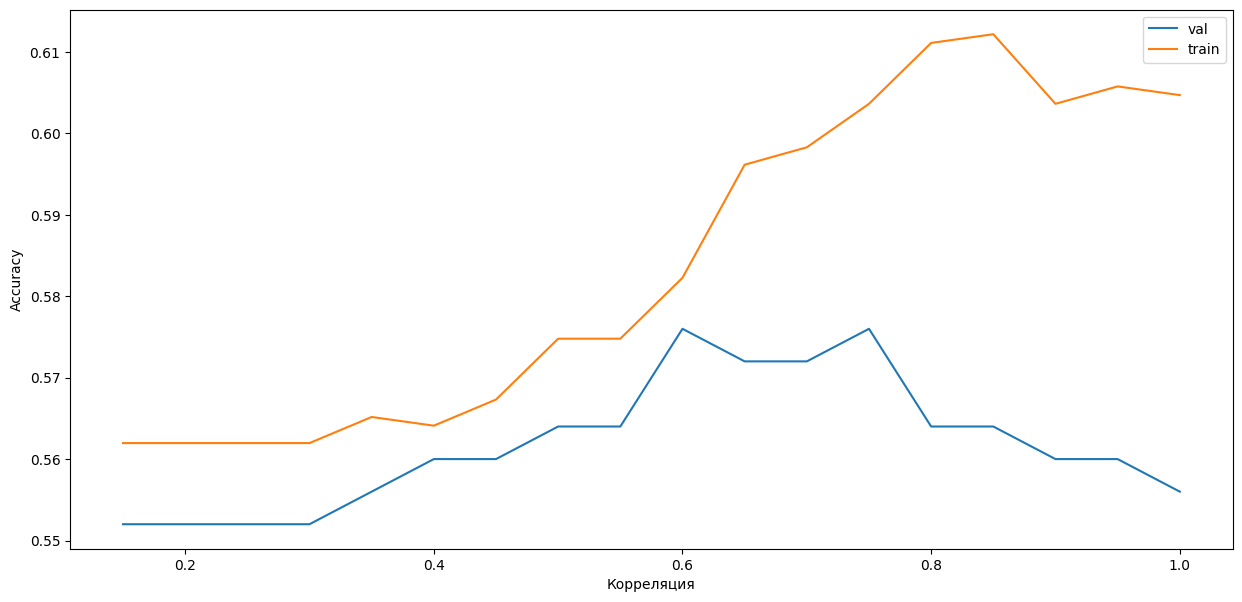

In [190]:
plt.figure(figsize=(15, 7))
plt.xlabel('Корреляция')
plt.ylabel('Accuracy')

sns.lineplot(x=thrs, y=acc_score_val, label='val')
sns.lineplot(x=thrs, y=acc_score_train, label='train')

Возьмем датасет с отобранными признаки, где корреляция не выше 0.4 между признаками

In [191]:
df_temp = rm_high_corr_feat(df, 0.65, 6)

train = df_temp.iloc[n:, :]
val = df_temp.iloc[:n, :]

y_train = train['team_1_hue']
x_train = train.drop('team_1_hue', axis=1)

y_val = val['team_1_hue']
x_val = val.drop('team_1_hue', axis=1)

In [192]:
df_temp

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,team_1_hue,_accurate_back_zone_pass_team_1,_accurate_corners_intobox_team_1,_accurate_freekick_cross_team_1,_accurate_goal_kicks_team_1,...,_overrun_lag_team2,_own_goal_accrued_lag_team2,_penalty_conceded_lag_team2,_pts_dropped_winning_pos_lag_team2,_pts_gained_losing_pos_lag_team2,_second_yellow_lag_team2,_shield_ball_oop_lag_team2,_six_yard_block_lag_team2,_subs_goals_lag_team2,_total_red_card_lag_team2
0,20,2023,Wolverhampton Wanderers,Everton,Molineux Stadium,1,7582.25,43.750000,16.500000,182.000000,...,41.0,2.000000,6.0,17.0,9.0,1.000000,24.0,14.0,2.000000,2.0
1,20,2023,Tottenham Hotspur,Bournemouth,Tottenham Hotspur Stadium,1,8308.50,41.750000,7.750000,217.000000,...,55.0,2.275362,7.0,15.0,12.0,1.581395,26.0,16.0,3.000000,2.5
2,20,2023,Nottingham Forest,Manchester United,The City Ground,1,5016.00,29.000000,15.000000,197.000000,...,29.0,2.000000,3.0,7.0,11.0,1.581395,34.0,14.0,7.000000,2.0
3,20,2023,Manchester City,Sheffield United,Etihad Stadium,1,10041.25,65.750000,11.500000,136.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,2023,Liverpool,Newcastle United,Anfield,1,9401.25,64.250000,16.000000,177.250000,...,51.0,5.000000,5.0,11.0,14.0,1.581395,21.0,27.0,7.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,1,10041.25,65.750000,11.500000,136.250000,...,70.0,1.000000,6.0,23.0,9.0,1.000000,22.0,21.0,4.285714,1.0
1182,1,2020,Liverpool,Leeds United,Anfield,1,9401.25,64.250000,16.000000,177.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,0,7339.00,53.000000,15.500000,199.000000,...,65.0,2.275362,8.0,21.0,18.0,1.000000,26.0,18.0,4.285714,5.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,1,6535.25,46.000000,21.500000,168.500000,...,80.0,2.275362,4.0,17.0,13.0,1.000000,25.0,24.0,4.285714,4.0


In [193]:
df_temp.to_csv('../prepare_data/data/df_temp_65.csv', index=False)

In [194]:
train_pool = Pool(x_train, label=y_train, cat_features=cat)
val_pool = Pool(x_val, label=y_val, cat_features=cat)

model = CatBoostClassifier(iterations=2000, loss_function='MultiClass')

param_grid = {
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.005],
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=None,                                                      
                           )

grid_search.fit(x_train, y_train, cat_features=cat, eval_set=(x_val, y_val), plot=True, verbose=False)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка точности:", grid_search.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Лучшие параметры: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.001}
Лучшая оценка точности: 0.5363807031516669


In [195]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.001}


In [196]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass')

model.fit(x_train, y_train, cat_features=cat, eval_set=(x_val, y_val),  verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [201]:
accuracy_score(y_val, model.predict(x_val))


0.584

## Data pickl

In [198]:
name_cols = 'pickle/name_cols.pickle'

col_pkl = list(df_temp.columns)
col_pkl.remove('team_1_hue')

with open(name_cols, 'wb') as file:
    pickle.dump(col_pkl, file)


In [199]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass', depth=4, l2_leaf_reg=6)
model.fit(x_train, y_train, cat_features=cat, verbose=False)

with open('pickle/catboost.pickle', 'wb') as file:
    pickle.dump(model, file)

In [200]:
x_train

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,_accurate_back_zone_pass_team_1,_accurate_corners_intobox_team_1,_accurate_freekick_cross_team_1,_accurate_goal_kicks_team_1,_accurate_keeper_sweeper_team_1,...,_overrun_lag_team2,_own_goal_accrued_lag_team2,_penalty_conceded_lag_team2,_pts_dropped_winning_pos_lag_team2,_pts_gained_losing_pos_lag_team2,_second_yellow_lag_team2,_shield_ball_oop_lag_team2,_six_yard_block_lag_team2,_subs_goals_lag_team2,_total_red_card_lag_team2
250,28,2022,Wolverhampton Wanderers,Leeds United,Molineux Stadium,7582.25,43.750000,16.500000,182.000000,13.00,...,50.0,2.275362,6.0,19.0,9.0,1.581395,17.0,14.0,4.285714,3.0
251,28,2022,Southampton,Tottenham Hotspur,St. Mary's Stadium,6161.75,46.000000,17.000000,140.250000,15.75,...,41.0,6.000000,3.0,7.0,14.0,1.000000,24.0,12.0,4.285714,1.0
252,28,2022,Nottingham Forest,Newcastle United,The City Ground,5016.00,29.000000,15.000000,197.000000,17.00,...,45.0,3.000000,6.0,24.0,14.0,1.000000,23.0,12.0,4.285714,2.0
253,34,2022,Manchester City,West Ham United,Etihad Stadium,10041.25,65.750000,11.500000,136.250000,17.00,...,40.0,3.000000,6.0,16.0,14.0,2.000000,18.0,16.0,4.285714,3.0
254,34,2022,Liverpool,Fulham,Anfield,9401.25,64.250000,16.000000,177.250000,31.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,10041.25,65.750000,11.500000,136.250000,17.00,...,70.0,1.000000,6.0,23.0,9.0,1.000000,22.0,21.0,4.285714,1.0
1182,1,2020,Liverpool,Leeds United,Anfield,9401.25,64.250000,16.000000,177.250000,31.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,7339.00,53.000000,15.500000,199.000000,15.00,...,65.0,2.275362,8.0,21.0,18.0,1.000000,26.0,18.0,4.285714,5.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,6535.25,46.000000,21.500000,168.500000,14.00,...,80.0,2.275362,4.0,17.0,13.0,1.000000,25.0,24.0,4.285714,4.0
